### Import Libraries

In [1]:
# importing libraries
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import numpy as np

### CUDA Setup

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Augumentation and Transformation

In [12]:
import torch
from torchvision import datasets, transforms as tt
from torch.utils.data import DataLoader

# Statistics for CIFAR10 (mean and std)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Data transformations
train_tfm = tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),  # Randomly crop the image with reflection padding
    tt.RandomHorizontalFlip(),  # Random horizontal flip
    tt.ToTensor(),  # Convert the image to a tensor
    tt.Normalize(*stats, inplace=True)  # Normalize with CIFAR10 mean and std
])

valid_tfm = tt.Compose([
    tt.ToTensor(),  # Convert the image to a tensor
    tt.Normalize(*stats)  # Normalize with CIFAR10 mean and std
])

# Download CIFAR10 dataset directly using torchvision
train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfm)  # Apply train transformations
valid_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_tfm)  # Apply validation transformations

# Data loaders
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)  # Batch size of 100 for training
valid_loader = DataLoader(valid_ds, batch_size=100, shuffle=False)  # Batch size of 100 for validation

# Determine device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a wrapper to move data to the device (GPU/CPU)
class DeviceDataLoader:
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device

    def __iter__(self):
        for batch in self.data_loader:
            yield [item.to(self.device) for item in batch]

# Create device-specific data loaders
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)


Files already downloaded and verified
Files already downloaded and verified


### Sample training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


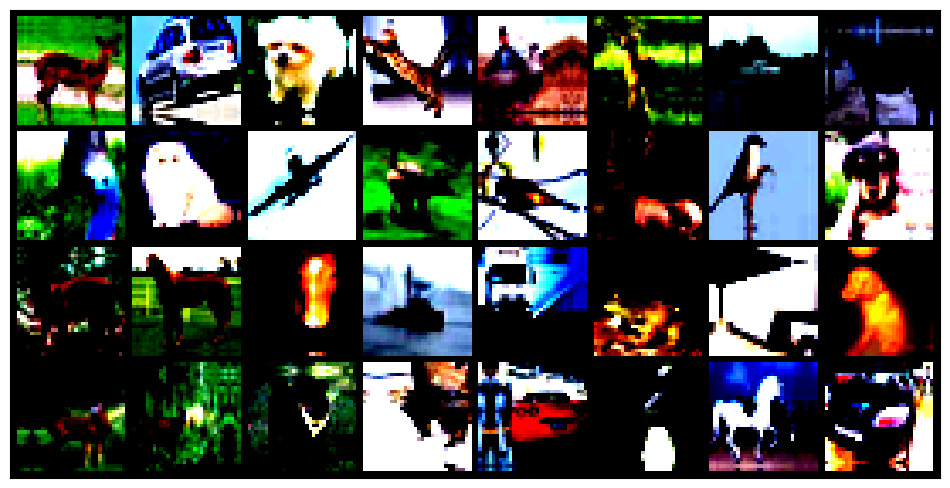

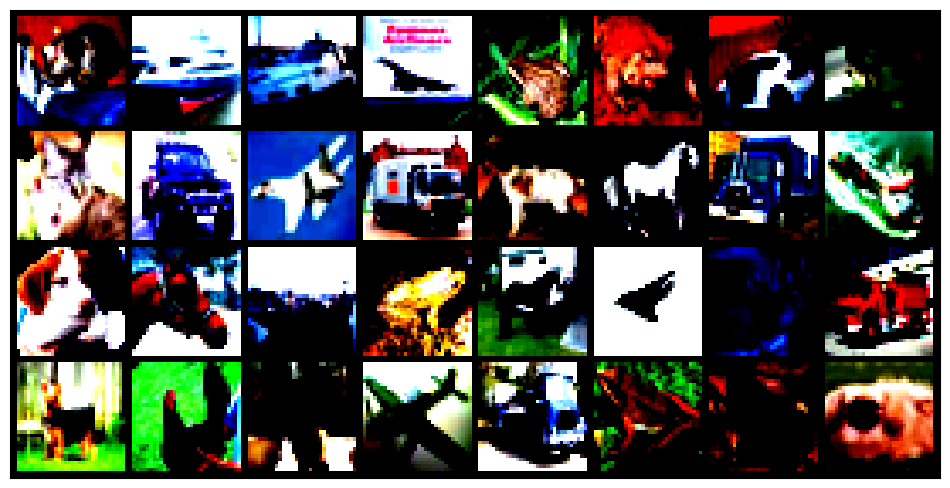

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax= plt.subplots(figsize=(12,12))
        ax.set_xticks([]) #hide ticks
        ax.set_yticks([])
        ax.imshow(make_grid(images[:32],nrow=8).permute(1,2,0))
        break # printing only first 64 images from first batch
show_batch(train_loader)
show_batch(valid_loader)

### Class definition 

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


### ResNet

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [17]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [item.to(device) for item in data]
    return data.to(device)

In [18]:
model= to_device(ResNet9(3,10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training the model

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,
                  save_path="best_model.pth"):
    torch.cuda.empty_cache()
    history = []
    best_val_loss = float('inf')  # Initialize best validation loss
    
    steps_per_epoch = len(train_loader.data_loader.dataset) // train_loader.data_loader.batch_size

    # Move model to GPU (if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=steps_per_epoch)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_loader:
            # Move data to GPU (if available)
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        
        val_epoch_loss = result['val_loss']  # Assume 'val_loss' is part of evaluation output
        
        # Save the best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), save_path)  # Save the best model
            print(f"Saved best model at epoch {epoch+1} with val_loss: {best_val_loss:.4f}")
        
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


In [35]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6147575378417969, 'val_acc': 0.7943000197410583}]

In [36]:
epochs = 70
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [37]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Saved best model at epoch 1 with val_loss: 0.3296
Epoch [0], train_loss: 0.3002, val_loss: 0.3296, val_acc: 0.8892
Saved best model at epoch 2 with val_loss: 0.3080
Epoch [1], train_loss: 0.2440, val_loss: 0.3080, val_acc: 0.8977
Epoch [2], train_loss: 0.2291, val_loss: 0.4198, val_acc: 0.8636
Epoch [3], train_loss: 0.2528, val_loss: 0.3591, val_acc: 0.8833
Epoch [4], train_loss: 0.2884, val_loss: 0.3883, val_acc: 0.8734
Epoch [5], train_loss: 0.3266, val_loss: 0.4210, val_acc: 0.8640
Epoch [6], train_loss: 0.3589, val_loss: 0.5331, val_acc: 0.8252
Epoch [7], train_loss: 0.3799, val_loss: 0.8425, val_acc: 0.7486
Epoch [8], train_loss: 0.4074, val_loss: 0.4692, val_acc: 0.8459
Epoch [9], train_loss: 0.4343, val_loss: 0.7255, val_acc: 0.7699
Epoch [10], train_loss: 0.4517, val_loss: 0.5688, val_acc: 0.8089
Epoch [11], train_loss: 0.4625, val_loss: 0.6750, val_acc: 0.7843
Epoch [12], train_loss: 0.4829, val_loss: 0.6283, val_acc: 0.7989
Epoch [13], train_loss: 0.4991, val_loss: 0.5633, va

### Validation accuracy

In [40]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize the model with the required arguments
model = ResNet9(in_channels=3, num_classes=10)  # Modify as per your use case
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set model to evaluation mode
model.to(device)  # Move model to the correct device (CPU or GPU)

# Define the loss function (for classification)
criterion = torch.nn.CrossEntropyLoss()

# Initialize variables to store results
all_preds = []
all_labels = []
val_loss = 0.0
val_corrects = 0.0

# Validation phase (no gradient needed)
with torch.no_grad():  # No gradient computation for validation
    for val_inputs, val_labels in valid_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        
        # Calculate validation loss
        loss = criterion(val_outputs, val_labels)
        val_loss += loss.item() * val_inputs.size(0)  # Multiply by batch size
        
        # Get predicted classes
        _, preds = torch.max(val_outputs, 1)
        
        # Count correct predictions
        val_corrects += torch.sum(preds == val_labels.data)
        
        # Store predictions and labels for metrics calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

# Calculate final validation loss and accuracy
num_val_samples = len(valid_loader.dataset)  # Total number of validation samples
final_val_loss = val_loss / num_val_samples
final_val_acc = (val_corrects.float() / num_val_samples) * 100  # Convert to percentage

# Calculate Precision, Recall, and F1 Score
final_precision = precision_score(all_labels, all_preds, average='weighted')
final_recall = recall_score(all_labels, all_preds, average='weighted')
final_f1 = f1_score(all_labels, all_preds, average='weighted')

# Display the results
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")
print(f"Final F1 Score: {final_f1:.4f}")


C:\Users\7501\AppData\Local\Temp\ipykernel_17016\3313685064.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Final Validation Loss: 0.2832
Final Validation Accuracy: 90.64%
Final Precision: 0.9061
Final Recall: 0.9064
Final F1 Score: 0.9062


### Plotting accuracy and loss

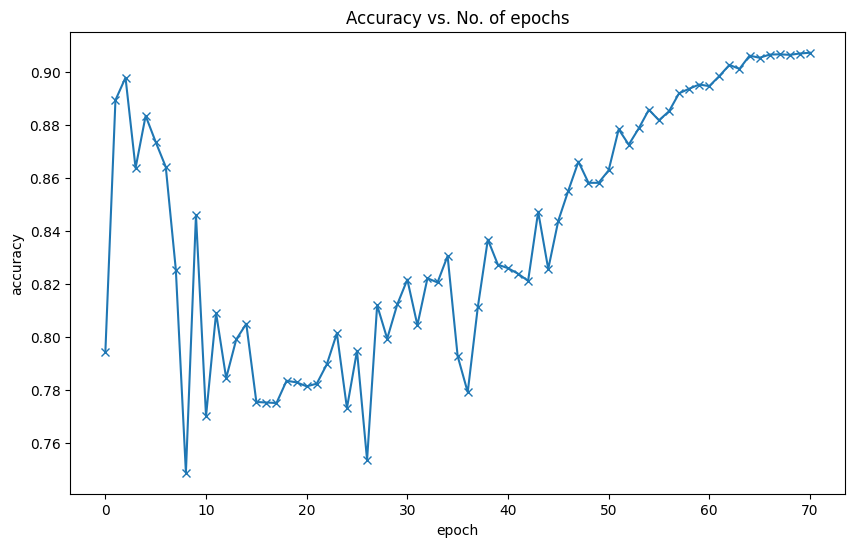

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

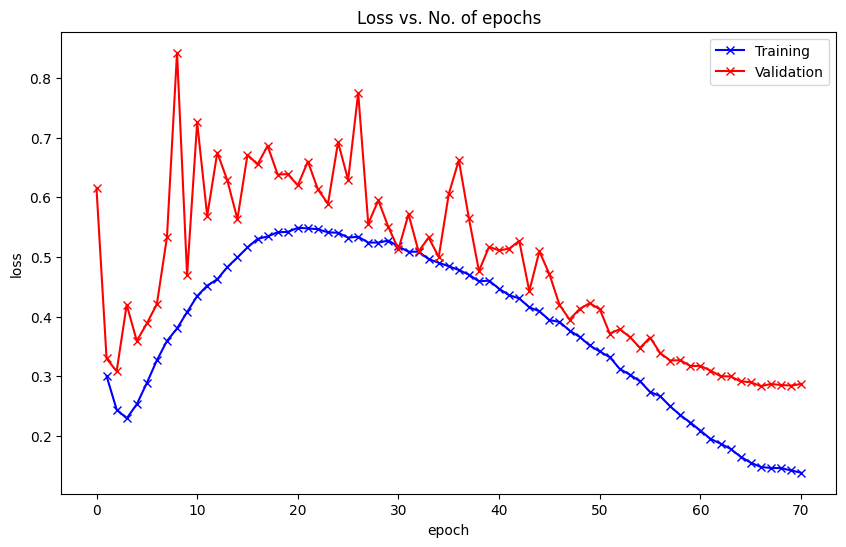

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

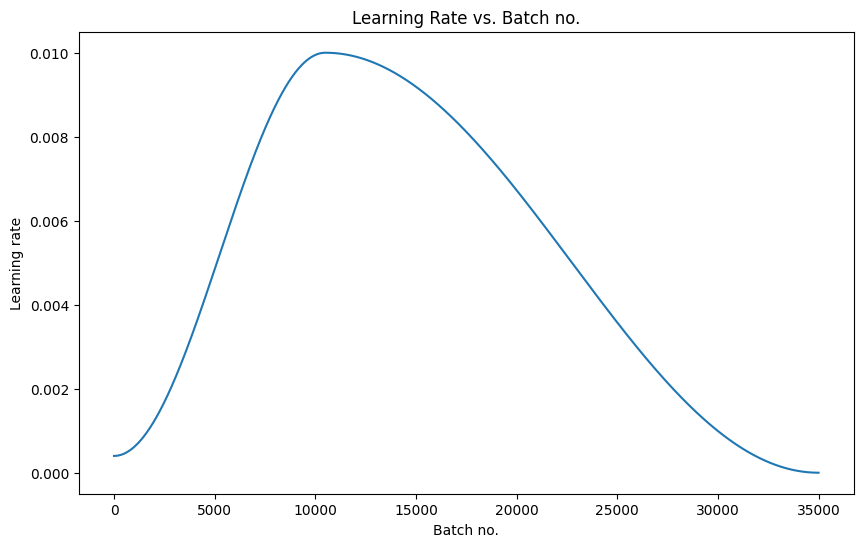

In [43]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.figure(figsize=(10,6))
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

### Test accuracy and loss

In [46]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [47]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import precision_score, recall_score, f1_score

# Define transformations for the test dataset
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

# Load the test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# Define the test loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define the test loader

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Iterate over the test data
for data, target in test_loader:
    # Move tensors to the GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    
    # Forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # Calculate the batch loss
    loss = criterion(output, target)
    
    # Update the total test loss
    test_loss += loss.item() * data.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Compare predictions to true labels
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = correct_tensor.cpu().numpy().squeeze()
    
    # Calculate test accuracy for each class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i]
        class_total[label] += 1

# Average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

# Display accuracy for each class
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100.0 * class_correct[i] / class_total[i]
        print(f'Test Accuracy of {classes[i]:>5s}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        print(f'Test Accuracy of {classes[i]:>5s}: N/A (no test examples)')

# Display overall test accuracy
overall_accuracy = 100.0 * sum(class_correct) / sum(class_total)
print(f'\nTest Accuracy (Overall): {overall_accuracy:.2f}% ({int(sum(class_correct))}/{int(sum(class_total))})')


Files already downloaded and verified
Test Loss: 0.694245

Test Accuracy of plane: 73.30% (733/1000)
Test Accuracy of   car: 78.30% (783/1000)
Test Accuracy of  bird: 78.30% (783/1000)
Test Accuracy of   cat: 84.40% (844/1000)
Test Accuracy of  deer: 91.60% (916/1000)
Test Accuracy of   dog: 58.30% (583/1000)
Test Accuracy of  frog: 79.40% (794/1000)
Test Accuracy of horse: 64.80% (648/1000)
Test Accuracy of  ship: 89.40% (894/1000)
Test Accuracy of truck: 67.00% (670/1000)

Test Accuracy (Overall): 76.48% (7648/10000)


### True Vs Predicted Labels

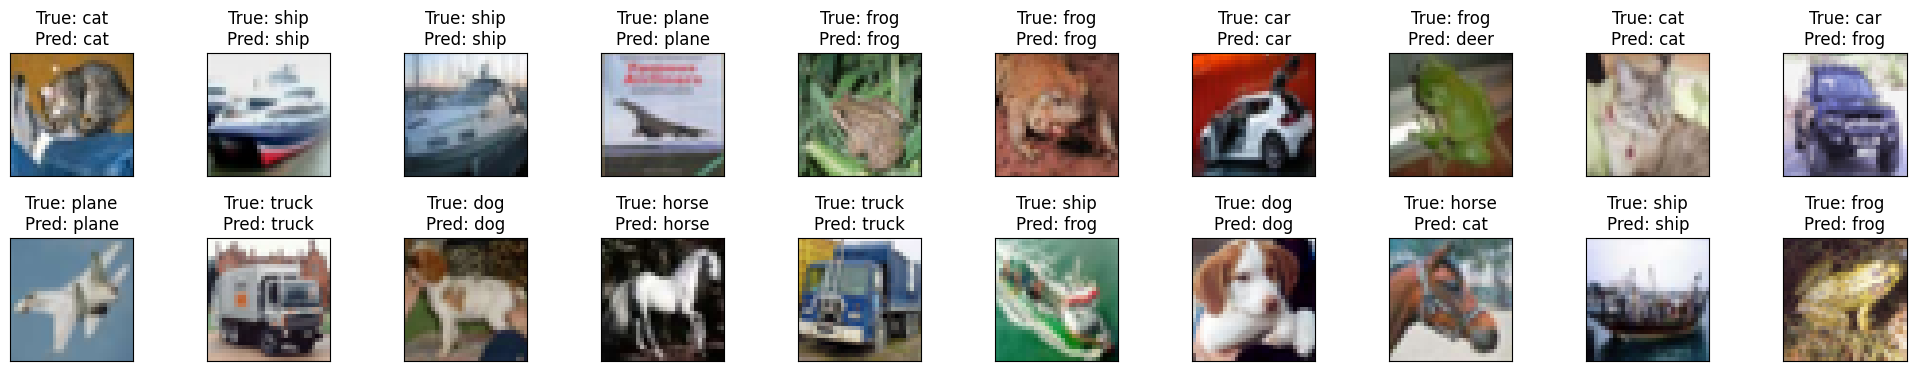

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# We iterate the batch of images to display
dataiter = iter(test_loader)  # Converting test_loader to iterable so that we can iterate through it
images, labels = next(dataiter)  # Using the built-in next() function
fig = plt.figure(figsize=(25, 4))  # Set figure size

# Predict the class labels for these images
output = model(images.to(device))  # Forward pass to get the model predictions
_, preds = torch.max(output, 1)  # Get the class with the highest probability

# Convert labels and predictions to their class names
true_labels = [classes[labels[j]] for j in range(len(labels))]
pred_labels = [classes[preds[j]] for j in range(len(preds))]

# We plot 20 images from the test dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[]) 
    plt.imshow(np.transpose(images[idx] / 2 + 0.5, (1, 2, 0)))  # Unnormalize and convert to numpy array
    ax.set_title(f'True: {true_labels[idx]}\nPred: {pred_labels[idx]}')

# Adjust the layout to add gap between rows
plt.subplots_adjust(hspace=0.5)  # Add vertical space between rows

plt.show()


### CPU Vs GPU Latencies (Pytorch)

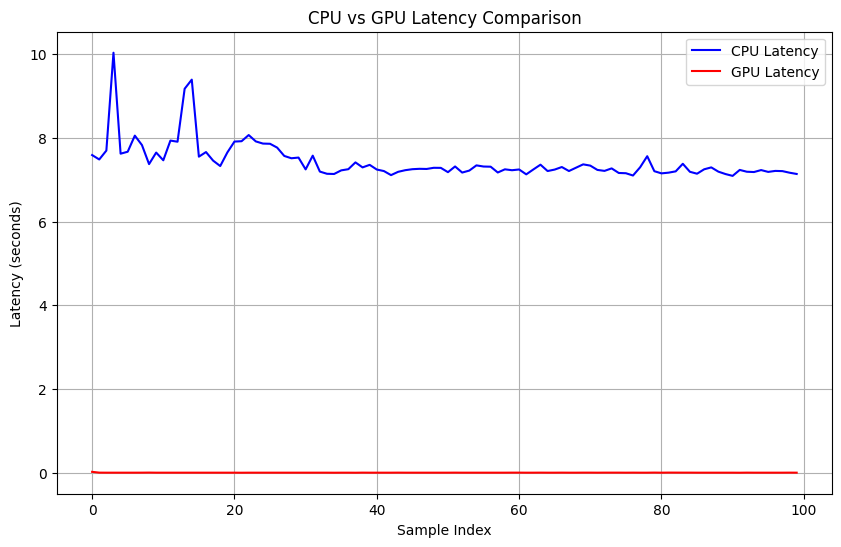

Average latency on CPU: 7.429853 seconds
Average latency on GPU: 0.002425 seconds


In [49]:
import time
def measure_latency(loader, device):
    latencies = []
    model.to(device)  # Move model to the specified device
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            start_time = time.time()
            model(data)
            latencies.append(time.time() - start_time)
    return latencies

# Measure latency on CPU
cpu_latencies = measure_latency(valid_loader, 'cpu')

# Measure latency on GPU (if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpu_latencies = measure_latency(valid_loader, device)

# Plot the comparison of latencies
plt.figure(figsize=(10, 6))
plt.plot(cpu_latencies, label='CPU Latency', color='blue')
plt.plot(gpu_latencies, label='GPU Latency', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Latency (seconds)')
plt.title('CPU vs GPU Latency Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print the average latencies
print(f"Average latency on CPU: {sum(cpu_latencies)/len(cpu_latencies):.6f} seconds")
print(f"Average latency on GPU: {sum(gpu_latencies)/len(gpu_latencies):.6f} seconds")

### Pytorch to ONNX

In [51]:
# Load a batch of validation data
inputs, _ = next(iter(valid_loader))  # Get the first batch of data from the validation loader

# Move the input tensor to the same device as the model (GPU)
inputs = inputs.to(device)

# Export the trained PyTorch model to ONNX using the validation batch
onnx_path = "best_model_final.onnx"

torch.onnx.export(
    model,
    inputs,  # Use the validation batch as input
    onnx_path,
    export_params=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"]
)

print(f"Model successfully exported to {onnx_path}")


Model successfully exported to best_model_final.onnx


In [52]:
import onnx
model = onnx.load("best_model_final.onnx")
onnx.checker.check_model(model)


### ONNX to TensorRT


trtexec --onnx=best_model_final.onnx --saveEngine=best_model_final.trt --fp16

### TensorRT Latency

In [57]:
import time
import numpy as np
import torch
import tensorrt as trt

# Load the TensorRT engine
def load_engine(engine_path):
    runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
    try:
        with open(engine_path, 'rb') as f:
            engine = runtime.deserialize_cuda_engine(f.read())
        if engine is None:
            raise ValueError("Failed to deserialize the engine.")
        return engine
    except Exception as e:
        print(f"Error loading engine: {e}")
        return None


# Perform inference and measure latency
def infer_and_measure_latency(engine, validation_loader):
    context = engine.create_execution_context()
    
    # Lists to store input and output bindings
    input_bindings = []
    output_bindings = []
    
    # Iterate through all tensors in the engine
    for i in range(engine.num_io_tensors):
        tensor_name = engine.get_tensor_name(i)
        size = trt.volume(engine.get_tensor_shape(tensor_name))  # Get the tensor size (volume)
        dtype = trt.nptype(engine.get_tensor_dtype(tensor_name))  # Get the tensor data type
        
        # Check whether the tensor is an input or output
        if engine.get_tensor_mode(tensor_name) == trt.TensorIOMode.INPUT:
            input_bindings.append((tensor_name, size, dtype))
        else:
            output_bindings.append((tensor_name, size, dtype))
    
    # Assuming the input shape is (batch_size, 3, 32, 32) and output shape is (batch_size, 10)
    # You may adjust this based on your model
    input_binding = input_bindings[0]  # First input binding
    output_binding = output_bindings[0]  # First output binding
    
    # Get the input shape directly from the engine
    input_shape = engine.get_tensor_shape(input_binding[0])
    batch_size = input_shape[0]  # The batch size is the first dimension
    
    # Get the output shape directly from the engine
    output_shape = engine.get_tensor_shape(output_binding[0])

    # Convert TensorRT Dims to tuple
    input_shape_tuple = tuple(input_shape)
    output_shape_tuple = tuple(output_shape)

    # Allocate host and device buffers
    d_input = torch.zeros(input_shape_tuple, dtype=torch.float32).cuda()  # Device input memory on GPU
    d_output = torch.zeros(output_shape_tuple, dtype=torch.float32).cuda()  # Device output memory on GPU

    latencies = []
    for inputs, _ in validation_loader:
        inputs = inputs.cuda()  # Move the inputs to GPU
        
        # Copy inputs to device memory
        d_input.copy_(inputs)
        
        start_time = time.perf_counter()
        context.execute_v2([d_input.data_ptr(), d_output.data_ptr()])  # Pass device memory pointers
        end_time = time.perf_counter()
        
        latencies.append(end_time - start_time)
    
    avg_latency = np.mean(latencies)
    return avg_latency

# Example usage
engine_path = "best_model_final.trt"
engine = load_engine(engine_path)
average_latency = infer_and_measure_latency(engine, valid_loader)
print(f"Average latency per batch: {average_latency:.6f} seconds")


Average latency per batch: 0.014245 seconds


In [1]:
import torch
print(torch.backends.cudnn.version())


90100
